In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import random
import time
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras import Model
from tensorflow.keras.layers import Flatten, Dense
from sklearn.metrics import accuracy_score
from tensorflow.math import log_sigmoid

In [2]:
# Load MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Select binary data
label_sub = [0,1]
x_train_sub = [x for x, y in zip(x_train, y_train) if y in label_sub]
y_train_sub = [y for y in y_train if y in label_sub]
x_test_sub = [x for x, y in zip(x_test, y_test) if y in label_sub]
y_test_sub = [y for y in y_test if y in label_sub]


print('There are', len(x_train_sub), 'training images.')
print('There are', len(x_test_sub), 'test images.')

There are 12665 training images.
There are 2115 test images.


In [3]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train_sub, y_train_sub)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test_sub, y_test_sub)).batch(32)

In [4]:
def convert2_zero_one(x):

    t = [tf.math.sigmoid(i) for i in x]
    
    return t

def rerange(x, r = 6.0):
    
    out_of_range = tf.cast(tf.math.greater(tf.math.abs(x), r), tf.float32)
    sign = tf.math.sign(x)
    
    return x * (1 - out_of_range) + sign * r * out_of_range

In [5]:
# MLP model
class StochasticMLP(Model):
    
    def __init__(self, hidden_layer_sizes = [100, 50], n_outputs=10):
        super(StochasticMLP, self).__init__()
        self.fc_layers = [Dense(layer_size) for layer_size in hidden_layer_sizes]
        self.output_layer = Dense(n_outputs)
        
    def call(self, x):

        x = Flatten()(x)
        network = []
        
        for i, layer in enumerate(self.fc_layers):
            
            logits = layer(x)
            x = tfp.distributions.Bernoulli(logits=logits).sample()
            network.append(x)

        final_logits = self.output_layer(x) # initial the weight of output layer
            
        return network
    
    def target_log_prob(self, x, h, y):
        
        x = Flatten()(x)
        y = [[i] for i in y]
        h_current = convert2_zero_one([tf.cast(h_i, dtype=tf.float32) for h_i in h])
        h_previous = [x] + h_current[:-1]
    
        nlog_prob = 0. # negative log probability
        
        #print("h_current:", h_current)
        #print("h_previous:", h_previous)
            
        for i, (cv, pv, layer) in enumerate(
            zip(h_current, h_previous, self.fc_layers)):
            
            ce = tf.nn.sigmoid_cross_entropy_with_logits(
                labels=cv, logits=layer(pv))
            
            nlog_prob += tf.reduce_sum(ce, axis = -1)
         
        print("y:", tf.cast(y, tf.float32))
        print("f_logits:", h_current[-1])
        fce = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.cast(y, tf.float32), logits=self.output_layer(h_current[-1]))
        nlog_prob += tf.reduce_sum(fce, axis = -1)
            
        return -1 * nlog_prob

    def target_log_prob2(self, x, h, y):
        
        x = Flatten()(x)
        y = [[i] for i in y]
        h_current = convert2_zero_one(tf.split(h, self.hidden_layer_sizes, axis = 1))
        #h_current = [h_current[0]]
        h_previous = [x] + h_current[:-1]
        
        nlog_prob = 0.
        
        for i, (cv, pv, layer) in enumerate(
            zip(h_current, h_previous, self.fc_layers)):
            
            ce = tf.nn.sigmoid_cross_entropy_with_logits(
                labels=cv, logits=layer(pv))
            
            nlog_prob += tf.reduce_sum(ce, axis = -1)
        
        fce = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.cast(y, tf.float32), logits=self.output_layer(h_current[-1]))
        nlog_prob += tf.reduce_sum(fce, axis = -1)
            
        return -1 * nlog_prob
    
    def generate_hmc_kernel(self, x, y, step_size = pow(1000, -1/4)):
        
        adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn = lambda v: self.target_log_prob2(x, v, y),
            num_leapfrog_steps = 2,
            step_size = step_size),
            num_adaptation_steps=int(100 * 0.8))
        
        return adaptive_hmc
    
    # new proposing-state method with HamiltonianMonteCarlo
    def propose_new_state_hamiltonian(self, x, h, y, hmc_ker):
    
        h_current = h
        h_current = [tf.cast(h_i, dtype=tf.float32) for h_i in h_current]
        h_current = tf.concat([h[0], h[1]], axis=1)

        # initialize the HMC transition kernel
        
        adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn = lambda v: self.target_log_prob2(x, v, y),
            num_leapfrog_steps = 2,
            step_size = pow(1000, -1/4)),
            num_adaptation_steps=int(100*0.8))

        # run the chain (with burn-in)
        num_results = 1
        num_burnin_steps = 100

        samples = tfp.mcmc.sample_chain(
            num_results = num_results,
            num_burnin_steps = num_burnin_steps,
            current_state = h_current, # may need to be reshaped
            kernel = adaptive_hmc,
            trace_fn = None)

        h_new = tf.split(samples[0], self.hidden_layer_sizes, axis = 1)

        return(h_new)
    
    def update_weights(self, x, h, y, lr = 0.1):
        
        optimizer = tf.keras.optimizers.SGD(learning_rate = lr)
        with tf.GradientTape() as tape:
            loss = -1 * tf.reduce_mean(self.target_log_prob(x, h, y))
        
        grads = tape.gradient(loss, self.trainable_weights)
        optimizer.apply_gradients(zip(grads, self.trainable_weights))

    def get_predictions(self, x):

        x = Flatten()(x)
        logits = 0.0
        for layer in self.fc_layers:
            logits = layer(x)
            x = tf.math.sigmoid(logits)
        
        logits = self.output_layer(x)
        probs = tf.math.sigmoid(logits)
        #print(probs)
        labels = tf.cast(tf.math.greater(probs, 0.5), tf.int32)

        return labels

In [6]:
model = StochasticMLP(hidden_layer_sizes = [100, 50], n_outputs = 1)

In [7]:
network = [model.call(images) for images, labels in train_ds]

In [8]:
network[0]

[<tf.Tensor: shape=(32, 100), dtype=int32, numpy=
 array([[0, 1, 1, ..., 1, 0, 1],
        [0, 1, 1, ..., 1, 0, 1],
        [1, 0, 0, ..., 1, 1, 0],
        ...,
        [1, 0, 1, ..., 1, 1, 0],
        [1, 0, 1, ..., 1, 1, 0],
        [0, 1, 1, ..., 1, 0, 1]], dtype=int32)>,
 <tf.Tensor: shape=(32, 50), dtype=int32, numpy=
 array([[0, 0, 1, ..., 1, 0, 0],
        [0, 1, 1, ..., 1, 1, 1],
        [1, 1, 0, ..., 1, 1, 1],
        ...,
        [1, 0, 0, ..., 0, 1, 0],
        [0, 1, 0, ..., 1, 1, 0],
        [0, 1, 1, ..., 1, 1, 1]], dtype=int32)>]

In [9]:
tlp = [model.target_log_prob(images, network[bs], labels) for bs, (images, labels) in enumerate(train_ds)]

y: tf.Tensor(
[[0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]], shape=(32, 1), dtype=float32)
f_logits: tf.Tensor(
[[0.5       0.5       0.7310586 ... 0.7310586 0.5       0.5      ]
 [0.5       0.7310586 0.7310586 ... 0.7310586 0.7310586 0.7310586]
 [0.7310586 0.7310586 0.5       ... 0.7310586 0.7310586 0.7310586]
 ...
 [0.7310586 0.5       0.5       ... 0.5       0.7310586 0.5      ]
 [0.5       0.7310586 0.5       ... 0.7310586 0.7310586 0.5      ]
 [0.5       0.7310586 0.7310586 ... 0.7310586 0.7310586 0.7310586]], shape=(32, 50), dtype=float32)
y: tf.Tensor(
[[1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]], shape=(32, 1), dtype=float32)
f_logits: tf.Tensor(
[[0.5       0.5       0.5       ... 0.7310

y: tf.Tensor(
[[1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]], shape=(32, 1), dtype=float32)
f_logits: tf.Tensor(
[[0.5       0.7310586 0.5       ... 0.7310586 0.5       0.7310586]
 [0.7310586 0.7310586 0.5       ... 0.7310586 0.7310586 0.7310586]
 [0.5       0.5       0.7310586 ... 0.5       0.5       0.7310586]
 ...
 [0.7310586 0.5       0.7310586 ... 0.7310586 0.5       0.7310586]
 [0.7310586 0.5       0.7310586 ... 0.5       0.7310586 0.7310586]
 [0.5       0.7310586 0.5       ... 0.5       0.7310586 0.7310586]], shape=(32, 50), dtype=float32)
y: tf.Tensor(
[[1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]], shape=(32, 1), dtype=float32)
f_logits: tf.Tensor(
[[0.5       0.7310586 0.5       ... 0.5   

y: tf.Tensor(
[[1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]], shape=(32, 1), dtype=float32)
f_logits: tf.Tensor(
[[0.5       0.7310586 0.5       ... 0.5       0.7310586 0.7310586]
 [0.7310586 0.7310586 0.5       ... 0.5       0.5       0.7310586]
 [0.5       0.5       0.5       ... 0.7310586 0.5       0.7310586]
 ...
 [0.5       0.5       0.5       ... 0.7310586 0.7310586 0.5      ]
 [0.5       0.5       0.5       ... 0.7310586 0.7310586 0.7310586]
 [0.5       0.5       0.7310586 ... 0.5       0.7310586 0.5      ]], shape=(32, 50), dtype=float32)
y: tf.Tensor(
[[1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]], shape=(32, 1), dtype=float32)
f_logits: tf.Tensor(
[[0.5       0.7310586 0.7310586 ... 0.5   

y: tf.Tensor(
[[1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]], shape=(32, 1), dtype=float32)
f_logits: tf.Tensor(
[[0.7310586 0.5       0.5       ... 0.5       0.7310586 0.7310586]
 [0.7310586 0.5       0.7310586 ... 0.7310586 0.7310586 0.5      ]
 [0.5       0.7310586 0.5       ... 0.5       0.5       0.7310586]
 ...
 [0.7310586 0.5       0.5       ... 0.7310586 0.7310586 0.5      ]
 [0.5       0.7310586 0.5       ... 0.5       0.5       0.7310586]
 [0.7310586 0.5       0.5       ... 0.5       0.5       0.7310586]], shape=(32, 50), dtype=float32)
y: tf.Tensor(
[[1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]], shape=(32, 1), dtype=float32)
f_logits: tf.Tensor(
[[0.5       0.5       0.5       ... 0.5   

y: tf.Tensor(
[[1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]], shape=(32, 1), dtype=float32)
f_logits: tf.Tensor(
[[0.5       0.5       0.7310586 ... 0.7310586 0.7310586 0.7310586]
 [0.5       0.5       0.5       ... 0.7310586 0.7310586 0.7310586]
 [0.5       0.5       0.7310586 ... 0.5       0.7310586 0.7310586]
 ...
 [0.5       0.7310586 0.5       ... 0.7310586 0.5       0.7310586]
 [0.5       0.7310586 0.5       ... 0.5       0.7310586 0.7310586]
 [0.5       0.5       0.5       ... 0.7310586 0.5       0.7310586]], shape=(32, 50), dtype=float32)
y: tf.Tensor(
[[1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]], shape=(32, 1), dtype=float32)
f_logits: tf.Tensor(
[[0.5       0.5       0.5       ... 0.7310

y: tf.Tensor(
[[0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]], shape=(32, 1), dtype=float32)
f_logits: tf.Tensor(
[[0.7310586 0.5       0.5       ... 0.5       0.5       0.7310586]
 [0.5       0.5       0.5       ... 0.7310586 0.5       0.7310586]
 [0.5       0.7310586 0.7310586 ... 0.5       0.5       0.7310586]
 ...
 [0.5       0.5       0.5       ... 0.5       0.7310586 0.5      ]
 [0.7310586 0.5       0.5       ... 0.5       0.5       0.7310586]
 [0.5       0.7310586 0.5       ... 0.7310586 0.5       0.7310586]], shape=(32, 50), dtype=float32)
y: tf.Tensor(
[[0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]], shape=(32, 1), dtype=float32)
f_logits: tf.Tensor(
[[0.7310586 0.5       0.7310586 ... 0.7310

y: tf.Tensor(
[[1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]], shape=(32, 1), dtype=float32)
f_logits: tf.Tensor(
[[0.7310586 0.7310586 0.5       ... 0.7310586 0.5       0.7310586]
 [0.7310586 0.5       0.5       ... 0.7310586 0.7310586 0.5      ]
 [0.7310586 0.5       0.5       ... 0.7310586 0.7310586 0.7310586]
 ...
 [0.5       0.7310586 0.5       ... 0.7310586 0.5       0.5      ]
 [0.5       0.5       0.5       ... 0.7310586 0.7310586 0.7310586]
 [0.7310586 0.7310586 0.7310586 ... 0.7310586 0.7310586 0.7310586]], shape=(32, 50), dtype=float32)
y: tf.Tensor(
[[1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]], shape=(32, 1), dtype=float32)
f_logits: tf.Tensor(
[[0.5       0.7310586 0.5       ... 0.5   

y: tf.Tensor(
[[0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]], shape=(32, 1), dtype=float32)
f_logits: tf.Tensor(
[[0.5       0.5       0.5       ... 0.7310586 0.5       0.7310586]
 [0.5       0.7310586 0.5       ... 0.5       0.5       0.5      ]
 [0.5       0.5       0.5       ... 0.7310586 0.5       0.5      ]
 ...
 [0.5       0.7310586 0.7310586 ... 0.5       0.5       0.5      ]
 [0.5       0.5       0.7310586 ... 0.7310586 0.5       0.7310586]
 [0.7310586 0.5       0.5       ... 0.5       0.7310586 0.7310586]], shape=(32, 50), dtype=float32)
y: tf.Tensor(
[[1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]], shape=(32, 1), dtype=float32)
f_logits: tf.Tensor(
[[0.7310586 0.7310586 0.5       ... 0.5   

y: tf.Tensor(
[[0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]], shape=(32, 1), dtype=float32)
f_logits: tf.Tensor(
[[0.5       0.5       0.7310586 ... 0.7310586 0.7310586 0.5      ]
 [0.5       0.5       0.5       ... 0.5       0.5       0.7310586]
 [0.7310586 0.7310586 0.5       ... 0.7310586 0.5       0.5      ]
 ...
 [0.5       0.5       0.5       ... 0.7310586 0.7310586 0.7310586]
 [0.5       0.7310586 0.7310586 ... 0.7310586 0.7310586 0.5      ]
 [0.5       0.5       0.5       ... 0.7310586 0.7310586 0.5      ]], shape=(32, 50), dtype=float32)
y: tf.Tensor(
[[0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]], shape=(32, 1), dtype=float32)
f_logits: tf.Tensor(
[[0.5       0.5       0.7310586 ... 0.7310

y: tf.Tensor(
[[0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]], shape=(32, 1), dtype=float32)
f_logits: tf.Tensor(
[[0.5       0.7310586 0.5       ... 0.7310586 0.7310586 0.5      ]
 [0.7310586 0.5       0.5       ... 0.7310586 0.7310586 0.7310586]
 [0.7310586 0.5       0.5       ... 0.7310586 0.7310586 0.5      ]
 ...
 [0.5       0.5       0.7310586 ... 0.7310586 0.5       0.7310586]
 [0.7310586 0.5       0.5       ... 0.7310586 0.5       0.7310586]
 [0.7310586 0.7310586 0.5       ... 0.5       0.7310586 0.7310586]], shape=(32, 50), dtype=float32)
y: tf.Tensor(
[[0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]], shape=(32, 1), dtype=float32)
f_logits: tf.Tensor(
[[0.5       0.5       0.5       ... 0.5   

y: tf.Tensor(
[[1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]], shape=(32, 1), dtype=float32)
f_logits: tf.Tensor(
[[0.7310586 0.7310586 0.5       ... 0.7310586 0.7310586 0.7310586]
 [0.7310586 0.7310586 0.5       ... 0.7310586 0.5       0.7310586]
 [0.5       0.5       0.5       ... 0.7310586 0.7310586 0.7310586]
 ...
 [0.7310586 0.5       0.5       ... 0.5       0.7310586 0.5      ]
 [0.5       0.7310586 0.5       ... 0.7310586 0.7310586 0.7310586]
 [0.7310586 0.7310586 0.5       ... 0.7310586 0.5       0.7310586]], shape=(32, 50), dtype=float32)
y: tf.Tensor(
[[1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]], shape=(32, 1), dtype=float32)
f_logits: tf.Tensor(
[[0.5       0.7310586 0.5       ... 0.7310

y: tf.Tensor(
[[0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]], shape=(32, 1), dtype=float32)
f_logits: tf.Tensor(
[[0.5       0.5       0.5       ... 0.7310586 0.5       0.5      ]
 [0.5       0.7310586 0.5       ... 0.5       0.7310586 0.5      ]
 [0.5       0.7310586 0.5       ... 0.7310586 0.7310586 0.5      ]
 ...
 [0.7310586 0.5       0.5       ... 0.5       0.5       0.7310586]
 [0.5       0.7310586 0.7310586 ... 0.7310586 0.5       0.7310586]
 [0.7310586 0.7310586 0.7310586 ... 0.7310586 0.7310586 0.5      ]], shape=(32, 50), dtype=float32)
y: tf.Tensor(
[[1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]], shape=(32, 1), dtype=float32)
f_logits: tf.Tensor(
[[0.7310586 0.5       0.7310586 ... 0.7310

y: tf.Tensor(
[[0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]], shape=(32, 1), dtype=float32)
f_logits: tf.Tensor(
[[0.7310586 0.7310586 0.5       ... 0.5       0.5       0.5      ]
 [0.5       0.7310586 0.5       ... 0.5       0.5       0.5      ]
 [0.7310586 0.7310586 0.5       ... 0.5       0.7310586 0.5      ]
 ...
 [0.7310586 0.5       0.7310586 ... 0.7310586 0.5       0.7310586]
 [0.7310586 0.5       0.5       ... 0.7310586 0.5       0.5      ]
 [0.7310586 0.5       0.5       ... 0.7310586 0.7310586 0.5      ]], shape=(32, 50), dtype=float32)
y: tf.Tensor(
[[1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]], shape=(32, 1), dtype=float32)
f_logits: tf.Tensor(
[[0.5       0.5       0.7310586 ... 0.7310

y: tf.Tensor(
[[0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]], shape=(32, 1), dtype=float32)
f_logits: tf.Tensor(
[[0.7310586 0.5       0.5       ... 0.7310586 0.5       0.5      ]
 [0.7310586 0.7310586 0.5       ... 0.7310586 0.5       0.7310586]
 [0.7310586 0.7310586 0.5       ... 0.7310586 0.5       0.5      ]
 ...
 [0.7310586 0.5       0.7310586 ... 0.5       0.5       0.7310586]
 [0.7310586 0.5       0.7310586 ... 0.7310586 0.7310586 0.5      ]
 [0.7310586 0.7310586 0.5       ... 0.7310586 0.7310586 0.7310586]], shape=(32, 50), dtype=float32)
y: tf.Tensor(
[[0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]], shape=(32, 1), dtype=float32)
f_logits: tf.Tensor(
[[0.7310586 0.5       0.5       ... 0.5   

y: tf.Tensor(
[[0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]], shape=(32, 1), dtype=float32)
f_logits: tf.Tensor(
[[0.5       0.7310586 0.5       ... 0.7310586 0.5       0.5      ]
 [0.5       0.5       0.5       ... 0.5       0.5       0.7310586]
 [0.5       0.5       0.5       ... 0.7310586 0.5       0.7310586]
 ...
 [0.5       0.5       0.7310586 ... 0.5       0.5       0.7310586]
 [0.7310586 0.7310586 0.7310586 ... 0.7310586 0.5       0.5      ]
 [0.7310586 0.7310586 0.5       ... 0.7310586 0.5       0.7310586]], shape=(32, 50), dtype=float32)
y: tf.Tensor(
[[0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]], shape=(32, 1), dtype=float32)
f_logits: tf.Tensor(
[[0.7310586 0.5       0.7310586 ... 0.7310

y: tf.Tensor(
[[0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]], shape=(32, 1), dtype=float32)
f_logits: tf.Tensor(
[[0.7310586 0.7310586 0.5       ... 0.5       0.5       0.7310586]
 [0.7310586 0.5       0.5       ... 0.5       0.7310586 0.5      ]
 [0.5       0.7310586 0.5       ... 0.5       0.7310586 0.7310586]
 ...
 [0.5       0.7310586 0.5       ... 0.7310586 0.5       0.5      ]
 [0.7310586 0.7310586 0.7310586 ... 0.5       0.7310586 0.5      ]
 [0.7310586 0.7310586 0.7310586 ... 0.7310586 0.5       0.7310586]], shape=(32, 50), dtype=float32)
y: tf.Tensor(
[[0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]], shape=(32, 1), dtype=float32)
f_logits: tf.Tensor(
[[0.7310586 0.5       0.5       ... 0.7310

In [24]:
np.shape(tlp)

/Users/hmy/anaconda3/envs/deeplearning/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(396,)

In [9]:
kernels = [model.generate_hmc_kernel(images, labels) for images, labels in train_ds]

/Users/hmy/anaconda3/envs/deeplearning/lib/python3.6/site-packages/tensorflow_probability/python/__init__.py:74: UserWarning: TensorFloat-32 matmul/conv are enabled for NVIDIA Ampere+ GPUs. The resulting loss of precision may hinder MCMC convergence. To turn off, run `tf.config.experimental.enable_tensor_float_32_execution(False)`. For more detail, see https://github.com/tensorflow/community/pull/287.
  'TensorFloat-32 matmul/conv are enabled for NVIDIA Ampere+ GPUs. The '


In [10]:
burnin = 20
step_sizes = []
for i in range(burnin):
    
    print(i)
    network_new = []
    kernels_new = []
    
    for (images, labels), net, hmc_kernel in zip(train_ds, network, kernels):
        net_current = net
        net_current = [tf.cast(net_i, dtype=tf.float32) for net_i in net_current]
        #net_current = tf.concat([net_current[0], net_current[1]], axis=1)
        net_current = tf.concat(net_current, axis = 1)
        
        num_results = 1
        num_burnin_steps = 0

        samples = tfp.mcmc.sample_chain(
            num_results = num_results,
            num_burnin_steps = num_burnin_steps,
            current_state = net_current, # may need to be reshaped
            kernel = hmc_kernel,
            #trace_fn = lambda _, pkr: pkr.inner_results.accepted_results.new_step_size,
            trace_fn = None,
            return_final_kernel_results = True)
        
        #print(samples[2].new_step_size.numpy())
        new_step_size = samples[2].new_step_size.numpy()
        step_sizes.append(new_step_size)

        new_state = rerange(samples[0][0])
        net_new = tf.split(new_state, [100, 50], axis = 1)   
        network_new.append(net_new)
        
        # build new kernel
        ker_new = model.generate_hmc_kernel(images, labels, new_step_size)
        kernels_new.append(ker_new)
            
    network = network_new
    kernels = kernels_new

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [11]:
print(network[0])

[<tf.Tensor: shape=(32, 100), dtype=float32, numpy=
array([[-3.1999784, -2.8211594,  4.369024 , ...,  4.070225 ,  4.576749 ,
         4.176324 ],
       [-4.843784 , -5.0149345,  4.37013  , ...,  5.500537 ,  4.371355 ,
         4.4155526],
       [-3.6694248, -4.904023 ,  4.0486245, ...,  4.748474 ,  6.       ,
         5.0594845],
       ...,
       [-5.29702  , -3.6096213,  3.4282207, ...,  4.742847 ,  3.8501425,
         5.726617 ],
       [-3.6177554,  3.0684032,  5.170508 , ...,  6.       ,  6.       ,
         5.716184 ],
       [-5.553438 , -3.4995112,  3.8661098, ...,  4.678867 ,  5.1382456,
         5.604164 ]], dtype=float32)>, <tf.Tensor: shape=(32, 50), dtype=float32, numpy=
array([[ 1.7347608 , -1.1314591 ,  3.1190722 , ..., -0.32078588,
        -4.2599163 ,  3.309264  ],
       [ 0.70246136,  0.33540776,  1.1967006 , ..., -0.716027  ,
        -2.1216116 ,  2.3646867 ],
       [-0.147183  ,  1.603231  ,  2.1467752 , ..., -0.18831506,
        -1.7463913 ,  0.19416738],
    

In [19]:
np.shape(step_sizes)

(7920,)

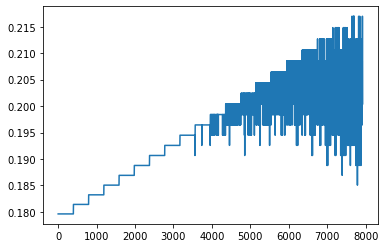

In [12]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(step_sizes)), step_sizes)
plt.show()

In [20]:
epochs = 500

start_time = time.time()
for epoch in range(epochs):
    
    loss = 0.0
    acc = 0.0
    for bs, (images, labels) in enumerate(train_ds):
        
        # only one mini-batch
        model.update_weights(images, network[bs], labels, 0.1)
        #network_new = [model.propose_new_state_hamiltonian(images, net, labels) for (images, labels), net in 
        #               zip(train_ds, network)]
        
        network_new = []
        #kernels_new = []
        for net, hmc_kernel in zip(network, kernels):
            net_current = net
            net_current = [tf.cast(net_i, dtype=tf.float32) for net_i in net_current]
            net_current = tf.concat(net_current, axis = 1)
            
            num_results = 1
            num_burnin_steps = 0

            samples = tfp.mcmc.sample_chain(
                num_results = num_results,
                num_burnin_steps = num_burnin_steps,
                current_state = net_current, # may need to be reshaped
                kernel = hmc_kernel,
                trace_fn = None,
                return_final_kernel_results = True)

            #new_step_size = samples[2].new_step_size.numpy()
            
            new_state = rerange(samples[0][0])
            net_new = tf.split(new_state, [100, 50], axis = 1)   
            network_new.append(net_new)
            
            #ker_new = model.generate_hmc_kernel(images2, labels2, new_step_size)
            #kernels_new.append(ker_new)
            
        network = network_new
        #kernels = kernels_new

        loss += -1 * tf.reduce_mean(model.target_log_prob(images, network[bs], labels))
       
    preds = [model.get_predictions(images) for images, labels in train_ds]
    #print(preds)
    train_acc = accuracy_score(np.array(preds[0]), y_train)
    print("Epoch %d/%d: - %.4fs/step - loss: %.4f - accuracy: %.4f" 
          % (epoch + 1, epochs, (time.time() - start_time) / (epoch + 1), loss, train_acc))

KeyboardInterrupt: 